# Environment Setup

## Imports, Setups, and Classes

In [1]:
import tensorflow as tf
from tensorflow.train import Feature, Features, Example

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import sys
from IPython.display import display 
from io import BytesIO
import os
from collections import namedtuple

# # How to import custom module? 
# # https://tinyurl.com/y7dfv2l7
# sys.path.append('/content/gdrive/My Drive/melanoma/')
# from utils.fealib import TFRECParser

from PIL import Image
from skimage import io
import logging
from multiprocessing import Process
import random

from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
class TFRECParser:
    """Class to parse the TFRecord files that come with the original dataset.
    """
    __TFREC_DESCRIPTOR = {"image_name": tf.io.FixedLenFeature([], tf.string),
                          "image": tf.io.FixedLenFeature([], tf.string)}

    def __init__(self) -> None:
        self.__dataset = None # tf.data.TFRecordDataset

    @tf.autograph.experimental.do_not_convert
    def load(self, path_tfrec: str = 'tfrecords/train*.tfrec') -> None:
        def parser(serialized_example: Example) -> Example:
            example = tf.io.parse_single_example(serialized_example,
                                                 features=TFRECParser.__TFREC_DESCRIPTOR)
            return example
        self.__dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(path_tfrec))
        self.__dataset = self.__dataset.map(parser)

    def get_dataset(self) -> tf.data.Dataset:
        return self.__dataset

    def get_image_arr(self, image_name: str) -> np.ndarray:
        record_dataset = self.__dataset.filter(lambda example: tf.equal(example["image_name"], image_name))
        example = next(iter(record_dataset))
        arr = tf.image.decode_jpeg(example['image'], channels=3).numpy()
        return arr

    def get_image(self, image_name: str) -> Image:
        return Image.fromarray(self.get_image_arr(image_name))

    def plot_image(self, image_name: str, figsize: list = [5, 5]) -> Image:
        img_arr = self.get_image_arr(image_name)
        img = Image.fromarray(img_arr)

        # prep title
        title = "{}, {}x{}, {:.2f}MB".format(image_name,
                                             img.size[0],
                                             img.size[1],
                                             sys.getsizeof(img_arr)/1024/1024)

        # render plot
        plt.figure(figsize=figsize)
        io.imshow(img_arr)
        plt.title(title)
        plt.show()

class Logger:
    """Class to provide basic functions for producing log files.
    """
    __loggers = {}
    __path = 'log.txt'

    @staticmethod
    def set_log_file_path(path: str) -> None:
        Logger.__path = path

    @staticmethod
    def get_logger(name: str) -> logging:
        # return instance if already exist
        if Logger.__loggers.get(name):
            return Logger.__loggers.get(name)

        # create a new isstance
        logger = logging.getLogger(name)
        logger.setLevel(logging.INFO)

        # build handler
        f_handler = logging.FileHandler(Logger.__path)
        formatter = logging.Formatter("[%(asctime)s] %(message)s",
                                    "%Y-%m-%d %H:%M:%S")
        f_handler.setFormatter(formatter)
        logger.addHandler(f_handler)

        # store logger to static arr
        Logger.__loggers[name] = logger

        return logger

class StdLogger:
    """Class to output stdouts to both console and log file.
    """
    
    def __init__(self) -> None:
        self.terminal_original = None
        self.terminal = None

    def open(self, log_file: str, flush_log_file: bool = False) -> None:
        self.terminal_original = sys.stdout
        if flush_log_file:
            self.terminal = open(log_file, "w")
        else:
            self.terminal = open(log_file, "a")
        sys.stdout = self.terminal

    def close(self) -> None:
        self.terminal.close()
        sys.stdout = self.terminal_original

# Generator[YieldType, SendType, ReturnType]
from typing import Generator, List, Dict, Tuple
from itertools import cycle
import math

class MelDSManager:
    """Data manager for Kaggle's SIIM-ISIC Melanoma Classification competition. The
    class is designed to perform the following cases:
        - Load & parse csv.
        - Load & transform train/test images.
        - Allow users create mini batches with configurable params including:
            - Forcing a certain ratio of positive/negative examples in each batch.
            - Applying custom image random transformation.
            - Customizing the batch size.
            - Limiting the number of loops through dataset.
            - Shuffling the order of examples.
            - Peform k-fold and hold-out splits.
            - etc.
    """
    def __init__(self) -> None:
        self.__df_train = None # pd DataFrame
        self.__df_test = None # pd DataFrame

        self.__dir_train = ''
        self.__dir_test = ''
        self.__img_fmt = 'jpg'
        self.__img_tranf_func = None # Callable

    @property
    def train_size(self) -> int:
        if self.__df_train is None:
            return 0
        return self.__df_train.shape[0]

    @property
    def train_df(self) -> pd.DataFrame:
        return self.__df_train

    @property
    def train_labels(self) -> np.ndarray:
        return self.__df_train.loc[:, "target"].to_numpy()

    @property
    def train_labels_one_hot(self) -> np.ndarray:
        return to_categorical(self.train_labels, num_classes=2)

    def get_train_img_arr(self, load_img: bool = False) -> np.ndarray:
        if not load_img:
            return self.__df_train.loc[:, 'image_name'].to_numpy()

        gen = self.get_train_batch_generator(loop=1,
                                             load_img_arr=load_img,
                                             remove_404=False,
                                             print_404=True,
                                             tranform_img=False,
                                             one_hot_encoding=False)
        return next(gen)['images']

    @property
    def test_size(self) -> int:
        if self.__df_test is None:
            return 0
        return self.__df_test.shape[0]

    def set_img_transform_func(self, func: callable) -> None:
        self.__img_tranf_func = func

    def set_img_format(self, fmt: str = 'jpg') -> bool:
        """The str will be suffixed to the image names (e.g. from IP_7887363 to 
        IP_7887363.jpg ) in csv to load the actual images.
        the actual images.
        """
        self.__img_fmt = fmt

    def set_img_dirs(self, dir_train: str, dir_test: str) -> bool:
        """The paths will be prefixed to the image names (e.g. IP_7887363) in csv 
        to load the actual images.
        Returns
            bool: True is both dir_train and dir_test exist; false otherwise.
        """
        if not (os.path.isdir(dir_train) and os.path.isdir(dir_test)):
            return False

        self.__dir_train = dir_train
        self.__dir_test = dir_test
        return True

    def set_dfs(self, train_df: pd.DataFrame, test_df: pd.DataFrame) -> None:
        self.__df_train = train_df
        self.__df_test = test_df
    
    def load_csv(self, train_csv_path: str, 
                 test_csv_path: str) -> List[pd.DataFrame]:
        """Method to load training and test csv files.
        Returns:
            list: [0] DF for training. [1] DF for testing.
        """
        self.__df_train = pd.read_csv(train_csv_path)
        self.__df_test = pd.read_csv(test_csv_path)
    
    def hold_out(self, 
                 n_hold: int, 
                 n_positive: int,
                 shuffle: bool = True, 
                 cls: 'class constructor' = None) -> Dict[str, 'MelDSManager']:
        """Hold out a specified number of examples for testing. Note that due to the 
        limited number of positive examples included in the dataset, the positive examples
        in 'hold' but will NOT be removed from 'train'.

        Args:
            n_hold (int): Number of examples to hold out for testing.
            shuffle (bool): Set true to shuffle the dataset.
            n_positive (int): Number of positive examples to be included.
            cls (class constructor): Child classes can pass in its class constructor; 
                                     otherwise, the hold-outs will be initiated as MelDSManager.
        
        Returns:
            List[MelDSManager]: A dictionary with two keys, 'train' and 'hold', 
                                each is a MelDSManager instance.
        """
        if cls is None:
            cls = MelDSManager

        # pull df
        train_positive_df = self.__df_train.loc[self.__df_train['target'] == 1, :]
        train_negative_df = self.__df_train.loc[self.__df_train['target'] == 0, :]

        # shuffle if required
        if shuffle:
            train_positive_df = train_positive_df.sample(frac=1).reset_index(drop=True)
            train_negative_df = train_negative_df.sample(frac=1).reset_index(drop=True)

        # create hold df
        n_negative = n_hold - n_positive
        hold_positive_df = train_positive_df.iloc[:n_positive, :]
        hold_negitve_df = train_negative_df.iloc[:n_negative, :]
        hold_df = pd.concat([hold_positive_df, hold_negitve_df])
        hold_df = hold_df.sample(frac=1).reset_index(drop=True) # shuffle

        # create train df
        # all positive examples will be kept for training
        train_positive_df = train_positive_df.iloc[:, :]
        train_negative_df = train_negative_df.iloc[n_negative:, :]
        train_df = pd.concat([train_positive_df, train_negative_df])
        train_df = hold_df.sample(frac=1).reset_index(drop=True) # shuffle

        dict_ = {}

        # create hold batch, a MelDSManager or child class instance
        dsm = cls()
        dsm.set_img_dirs(self.__dir_train, self.__dir_test)
        dsm.set_img_format(self.__img_fmt)
        dsm.set_img_transform_func(self.__img_tranf_func)
        dsm.set_dfs(hold_df, self.__df_test.iloc[:, :])
        dict_['hold'] = dsm

        # create train batch, a MelDSManager or child class instance
        dsm = cls()
        dsm.set_img_dirs(self.__dir_train, self.__dir_test)
        dsm.set_img_format(self.__img_fmt)
        dsm.set_img_transform_func(self.__img_tranf_func)
        dsm.set_dfs(train_df, self.__df_test.iloc[:, :])
        dict_['train'] = dsm

        return dict_

    def k_fold_split(self, 
                     k: int, 
                     shuffle: bool = True, 
                     cls: 'class' = None) -> List['MelDSManager']:
        """Split training dataset into k folds.

        Args:
            k (int): Number of folds.
            shuffle (bool): Set true to shuffle the dataset.
            cls (class constructor): Child classes can pass in its class constructor; 
                                     otherwise, the hold-outs will be initiated as MelDSManager.

        Returns:
            List[MelDSManager]: A list of k MelDSManager instances, each comes with 
                                the same test but different training sets.
        """
        if cls is None:
            cls = MelDSManager

        # copy and shuffle train
        train_df = self.__df_train.iloc[:, :]
        if shuffle:
            train_df = train_df.sample(frac=1).reset_index(drop=True)
        
        # split training data
        fold_size = self.__df_train.shape[0] // k
        train_df_splits = []
        for i in range(k):
            # calculate start/end index
            i_start = i * fold_size
            i_end = i_start + fold_size
            if i_end > self.__df_train.shape[0]:
                i_end = self.__df_train.shape[0]

            # construct fold
            fold_i = self.__df_train.iloc[i_start:i_end, :]
            train_df_splits.append(fold_i)
        
        # build folds
        folds = []
        for df in train_df_splits:
            dsm = cls()
            dsm.set_img_dirs(self.__dir_train, self.__dir_test)
            dsm.set_img_format(self.__img_fmt)
            dsm.set_img_transform_func(self.__img_tranf_func)
            dsm.set_dfs(df, self.__df_test.iloc[:, :])

            folds.append(dsm)

        return folds
        
    def shuffle_train(self) -> None:
        """Shuffle the training dataset. 
        
        When calling get_train_batch_generator(), examples will always be read in 
        the order of the rows as they are stored in csv. Without shuffling, you 
        would always end up with the same cases in each of the batches.
        """
        self.__df_train = self.__df_train.sample(frac=1).reset_index(drop=True)
    
    def get_train_batch_generator(self, 
                                  loop: int = -1, 
                                  batch_size: int = -1,
                                  max_batch_num: int = -1,
                                  positive_case_pct: float = -1,
                                  load_img_arr: bool = False,
                                  flatten_img_arr: bool = False,
                                  remove_404: bool = False,
                                  print_404: bool = False,
                                  tranform_img: bool = True,
                                  one_hot_encoding: bool = False) -> Generator[dict, None, None]:
        """
        Args:
            load_img_arr (bool): Set true to load the JPEG and convert to np.ndarray.
            loop (int): Param to set how many loops returned generator will go 
                through the training dataset.

            batch_size (int): Size of the mini-batch; must be larger than 1; set 
                to -1 for the full batch.
            
            max_batch_num (int): Maximum # of batches the returned generator will 
                produce. Iteration will end if max_batch_num is reached before the 
                end of the loop (and vice versa). Set to -1 to remove the max limit.
            
            positive_case_pct (float): Force a percentage of the examples included 
                in the batch to be positive cases (i.e. target=1). Set to -1 to 
                remove the restriction. 
            flatten_img_arr (bool): Convert the 3d image array to 1d.
            remove_404 (bool): Set true to remove images that fail to load from the batch.
            print_404 (bool): Print out the paths to images that fail to load.
            tranform_img (bool): Apply random transformation to the images loaded.
        Returns:
            Generator[dict, None, None]: A dictionary of np.ndarray. Generator will 
                continue until end of looping.
                'images':   Array of JPEGs in np.ndarray; this field will be filled 
                            only if load_img_arr is set to True.
                'urls':     Array of image URLs; image_name column in csv, prefixed 
                            with the path to the image director.
                'labels':   Array of labels; target column in csv.
                'others':   Array of pd.Series that contains the rest of the columns 
                            in CSV.

                Note that the last batch will loop back to the beginning of the 
                training data set if the training size is not an exact multiple of 
                the batch size.
        """
        # get the "real" batch size
        if batch_size < 0:
            batch_size = self.__df_train.shape[0]
        elif batch_size == 0:
            batch_size = 1

        # get generator
        if positive_case_pct == -1:
            yield from self.__loop_train_df(df=self.__df_train,
                                            loop=loop, 
                                            batch_size=batch_size, 
                                            max_batch_num=max_batch_num,
                                            load_img_arr=load_img_arr,
                                            flatten_img_arr=flatten_img_arr,
                                            remove_404=remove_404,
                                            print_404=print_404,
                                            tranform_img=tranform_img,
                                            one_hot_encoding=one_hot_encoding)
        else:
            # split the +ve and -ve cases
            df_positive = self.__df_train.loc[self.__df_train['target'] == 1, :]
            df_negative = self.__df_train.loc[self.__df_train['target'] == 0, :]

            # input validation
            if positive_case_pct > 1:
                positive_case_pct = 1

            # calculate the number of positive & negative cases to be included 
            # in the batch
            n_positive = math.floor(batch_size * positive_case_pct)
            n_negative = batch_size - n_positive

            # get the generators
            # Note that gen_positive is set to infinite looping. Looping for 
            # gen_positivewill only stop when gen_negative stops.
            gen_negative = self.__loop_train_df(df=df_negative,
                                                loop=loop, 
                                                batch_size=n_negative, 
                                                max_batch_num=max_batch_num,
                                                load_img_arr=load_img_arr,
                                                flatten_img_arr=flatten_img_arr,
                                                remove_404=remove_404,
                                                print_404=print_404,
                                                tranform_img=tranform_img,
                                                one_hot_encoding=one_hot_encoding)
            gen_positive = self.__loop_train_df(df=df_positive,
                                                loop=-1, 
                                                batch_size=n_positive, 
                                                load_img_arr=load_img_arr,
                                                flatten_img_arr=flatten_img_arr,
                                                remove_404=remove_404,
                                                print_404=print_404,
                                                tranform_img=tranform_img,
                                                one_hot_encoding=one_hot_encoding)
            
            for examples_negative in gen_negative:
                examples_positive = next(gen_positive)

                images = np.append(examples_negative['images'],
                                   examples_positive['images'],
                                   axis=0)

                urls = np.append(examples_negative['urls'],
                                 examples_positive['urls'],
                                 axis=0)
                labels = np.append(examples_negative['labels'],
                                   examples_positive['labels'],
                                   axis=0)
                others = pd.concat([examples_negative['others'],
                                    examples_positive['others']]).reset_index(drop=True)

                yield {'images': images, 'urls': urls, 'labels': labels, 'others': others}

    
    def __loop_train_df(self, 
                        df: pd.DataFrame,
                        loop: int = -1, 
                        batch_size: int = -1,
                        max_batch_num: int = -1,
                        positive_case_pct: float = -1,
                        load_img_arr: bool = False,
                        flatten_img_arr: bool = False,
                        remove_404: bool = False,
                        print_404: bool = False, 
                        tranform_img: bool = True,
                        one_hot_encoding: bool = False) -> Generator[dict, None, None]:
        """Method to loop through the df given.
        """
        index = 0
        # If loop starts as a positive number, while will stop when loop drops to 0.
        # If loop starts as a negative number, while becomes infinite.
        while (loop != 0):
            if max_batch_num == 0:
                break;
            
            # extract appropriate rows from df to batch_df
            index_end = index + batch_size
            batch_df = None
            if index_end < df.shape[0]:
                batch_df = df.iloc[index: index_end, :]
                index = index_end
            else:
                # retrieve the indices for the rows to be included
                rows = []
                i_list = list(range(index, df.shape[0])) + list(range(0, index))
                n = batch_size
                for i in cycle(i_list):
                    rows += [i]
                    n -= 1
                    if n == 0:
                        break

                batch_df = df.iloc[rows, :]
                index = rows[len(rows) - 1]
                loop -= 1
            
            max_batch_num -= 1
            yield self.__parse_csv_df(df=batch_df,
                                      load_img_arr=load_img_arr, 
                                      flatten_img_arr=flatten_img_arr, 
                                      remove_404=remove_404,
                                      print_404=print_404,
                                      tranform_img=tranform_img,
                                      one_hot_encoding=one_hot_encoding)

    def __parse_csv_df(self, 
                       df: pd.DataFrame,
                       load_img_arr: bool = False,
                       flatten_img_arr: bool = False,
                       remove_404: bool = False,
                       print_404: bool = False, 
                       tranform_img: bool = True,
                       one_hot_encoding: bool = False) -> dict:
        """Method to parse the df created out of the csv.
        Returns: 
            dict: A dictionary of np.ndarray. Generator will continue until end of looping.

                'images':   Array of JPEGs in np.ndarray; this field will be filled 
                            only if load_img_arr is set to True.
                'urls':     Array of image URLs; image_name column in csv, prefixed 
                            with the path to the image director.
                'labels':   Array of labels; target column in csv.
                'others':   Array of pd.Series that contains the rest of the columns 
                            in CSV.
        """

        urls = self.__dir_train + df.loc[:, 'image_name'] + '.' + self.__img_fmt
        urls = urls.to_numpy()
        labels = df.loc[:, 'target'].to_numpy()
        others = df.loc[:, 
                        (df.columns != 'image_name') & 
                        (df.columns != 'target')].reset_index(drop=True)
            
        images = []
        load_success_arr = []
        if load_img_arr:
            for url in urls.tolist():
                try:
                    img = np.array(Image.open(url))
                    load_success_arr.append(True)
                except:
                    img = None
                    load_success_arr.append(False)
                    if print_404:
                        print('404:', url)
                images.append(img)

            # transform img if required
            # Note: images is a list at this point...
            if tranform_img:
                images = list(map(self.__img_tranf_func, images))
            images = np.array(images)

            if remove_404:
                images = images[load_success_arr]
                urls = urls[load_success_arr]
                labels = labels[load_success_arr]
                others = others.iloc[load_success_arr, :]
            
            if one_hot_encoding:
                labels = to_categorical(labels, num_classes=2)
                
        return {'images': images, 'urls': urls, 'labels': labels, 'others': others}

    __ANGLES= [0, 90, 180, 270]
    __FLIPS= [Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM]
    @property
    def default_img_transform_func(self) -> callable:
        """Return the default image transform function.
        """
        def transform(img_arr: np.ndarray) -> np.ndarray:
            if img_arr is None:
                return

            # config constants
            # PIL doc: https://tinyurl.com/yceqdcxj
            ROTATION = 5
            ZOOM_RATIO = [0.95, 1.05]
            V_FLIP = random.randint(0, 1)
            H_FLIP = random.randint(0, 1)

            # calculate transformations
            angle =  MelDSManager.__ANGLES[random.randint(0, len(MelDSManager.__ANGLES) - 1)]
            angle += random.randint(-ROTATION, ROTATION)
            flip = MelDSManager.__FLIPS[random.randint(0, len(MelDSManager.__FLIPS) - 1)]
            zoom_w = round(1024 * random.uniform(ZOOM_RATIO[0], ZOOM_RATIO[1]))
            left = top = (zoom_w - 1024)/2
            right = bottom = (zoom_w + 1024)/2

            img = Image.fromarray(img_arr)

            # transform
            img = img.rotate(angle)
            img = img.transpose(Image.TRANSPOSE)  

            # zooming
            img = img.resize((zoom_w, zoom_w))
            img = img.crop((left, top, right, bottom))
            

            return np.array(img)

            # ImageDataGenerator is a lot slower for some reason...
            # gen = ImageDataGenerator(fill_mode='constant',
            #                          dtype=np.uint8) 

            # # rotation
            # rotation = [0, 90, 180, 270][random.randint(0, 3)]
            # rotation += random.randint(-ROTATION, ROTATION)

            # return gen.apply_transform(x=img_arr, 
            #                                 transform_parameters={'theta': rotation,
            #                                                       'flip_horizontal': V_FLIP,
            #                                                       'flip_vertical': H_FLIP})

        return transform

class KerasDSManager(MelDSManager):
    def __init__(self) -> None:
        super().__init__()
        super().set_img_transform_func(super().default_img_transform_func)

        # track down the first and latest batches generated by self.get_cnn_tbg()
        self._last_batch = None
        self._first_batch = None

    @property
    def last_batch(self) -> tuple:
        """Return the last batch generated by self.get_cnn_tbg().
        
        Returns:
            tuple(MelDSManager, MelDSManager): A tuple with the first item being 
                an 'images' array and second item being a 'labels' array.

                Description of the items in tuple:                 
                [0], i.e. 'images': Array of JPEGs in np.ndarray; this field 
                                    will be filled only if load_img_arr is set 
                                    to True.
                [1], i.e. 'labels': Array of labels; target column in csv.
        """
        return self._last_batch

    @property
    def first_batch(self) -> tuple:
        """Return the first batch generated by self.get_cnn_tbg(). Refer to last_batch.
        """
        return self._last_batch
    
    def get_cnn_tbg(self, *args, **kwargs) -> Generator[tuple, None, None]:
        """TBG stands for "Training Batch Generator." This method is exactly the 
        same as MelDSManager.get_train_batch_generator(). The only difference is the 
        returned format.

        Returns:
            tuple(MelDSManager, MelDSManager): A tuple with the first item being 
                an 'images' array and second item being a 'labels' array.

                Description of the items in tuple:                 
                [0], i.e. 'images': Array of JPEGs in np.ndarray; this field 
                                    will be filled only if load_img_arr is set 
                                    to True.
                [1], i.e. 'labels': Array of labels; target column in csv.
        """
        gen = super().get_train_batch_generator(*args, **kwargs)
        for batch in gen:
            self._last_batch = (batch['images'], batch['labels'])
            if self._first_batch is None:
                self._first_batch = self._last_batch
            
            yield self._last_batch

    def hold_out(self, *args, **kwargs) -> Dict[str, 'MelDSManager']:
        return super().hold_out(cls=KerasDSManager, *args, **kwargs)

    def k_fold_split(self, *args, **kwargs) -> List['MelDSManager']:
        return super().k_fold_split(cls=KerasDSManager, *args, **kwargs)

## Testing - MelDSManager & KerasDSManager

[0 0 0 0 0 1 1 1 1 1]
1594501577.2066212
[0 0 0 0 0 1 1 1 1 1]
0.8875706195831299
[0 0 0 0 0 1 1 1 1 1]
0.8832278251647949
[0 0 0 0 0 1 1 1 1 1]
0.8866183757781982
[0 0 0 0 0 1 1 1 1 1]
0.8789722919464111


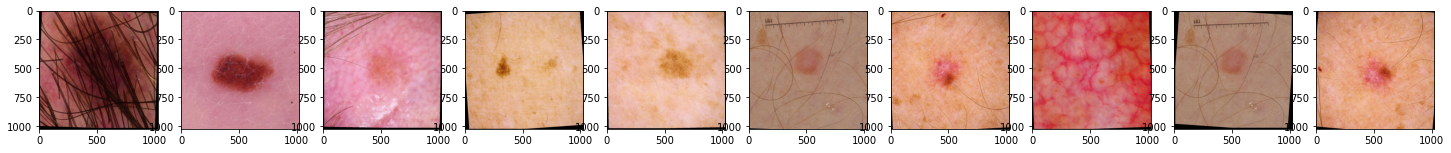

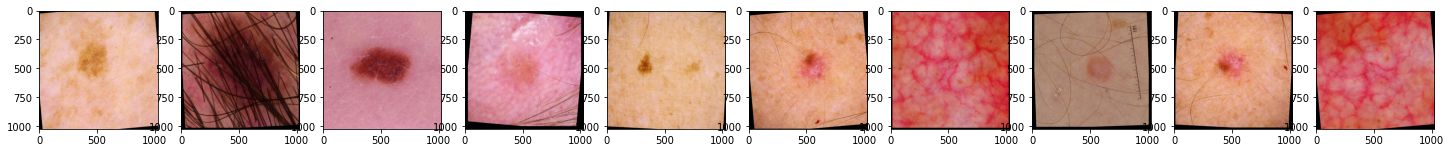

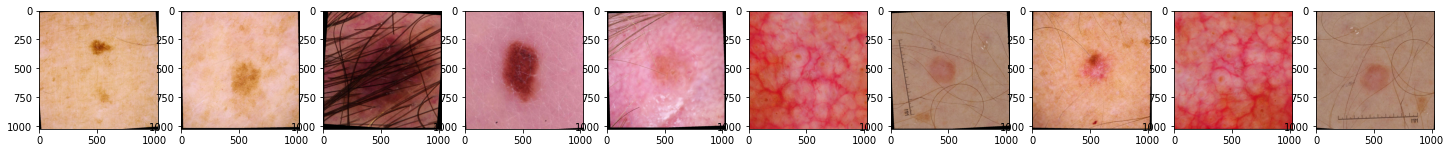

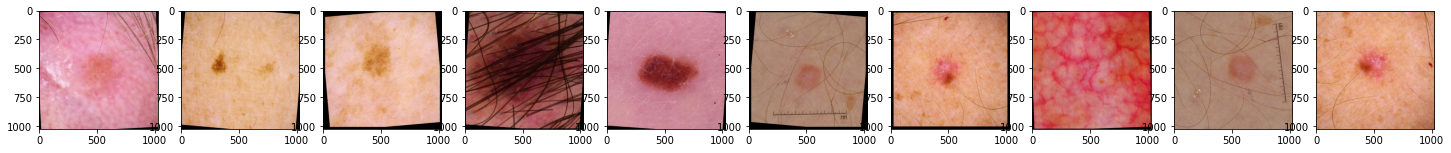

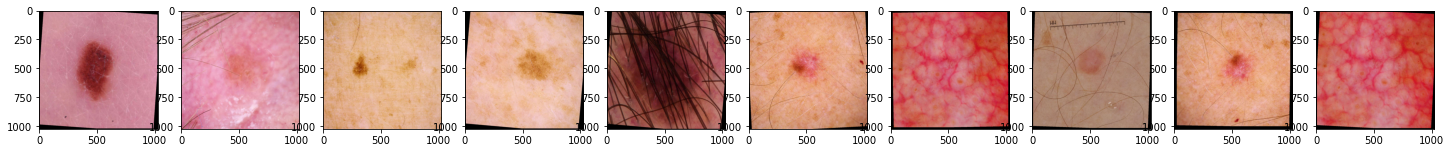

In [9]:
# Batching Demo

import time

CSV_TRAIN = '/content/gdrive/My Drive/Kaggle/melanoma/csv/_temp/train_testing.csv'
CSV_TEST = '/content/gdrive/My Drive/Kaggle/melanoma/csv/test.csv'
DIR_TRAIN_IMG = '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/'
DIR_TEST_IMG =  '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/test/'
IMG_FMT = 'jpg'

# initialize dataset manager
dsm = MelDSManager()
if not dsm.set_img_dirs(DIR_TRAIN_IMG, DIR_TEST_IMG):
    print('\nImage directories do not exist...\n')
dsm.set_img_format(IMG_FMT)
dsm.set_img_transform_func(dsm.default_img_transform_func)

# load data
dsm.load_csv(CSV_TRAIN, CSV_TEST)
dsm.shuffle_train()

# standard batch generator
gen = dsm.get_train_batch_generator(loop=-1, 
                                    max_batch_num=5,
                                    batch_size=10,
                                    positive_case_pct=0.5,
                                    load_img_arr=True,
                                    flatten_img_arr=False,
                                    remove_404=False,
                                    print_404=True,
                                    tranform_img=True,
                                    one_hot_encoding=False)

t0, t1 = 0, 0
for i, v in enumerate(gen):
    t1 = time.time()
    print(v['labels'])
    images = v['images']
    print(t1-t0)
    t0 = time.time()
    
    fig, axes = plt.subplots(1, images.shape[0], figsize=(25, 10))
    for j, img in enumerate(images):
        axes[j].imshow(img)

In [ ]:
# Keras Batching Demo

import time

CSV_TRAIN = '/content/gdrive/My Drive/Kaggle/melanoma/csv/_temp/train_testing.csv'
CSV_TEST = '/content/gdrive/My Drive/Kaggle/melanoma/csv/test.csv'
DIR_TRAIN_IMG = '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/'
DIR_TEST_IMG =  '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/test/'
IMG_FMT = 'jpg'

# initialize dataset manager
dsm = KerasDSManager()
if not dsm.set_img_dirs(DIR_TRAIN_IMG, DIR_TEST_IMG):
    print('\nImage directories do not exist...\n')
dsm.set_img_format(IMG_FMT)
dsm.set_img_transform_func(dsm.default_img_transform_func)

# load data
dsm.load_csv(CSV_TRAIN, CSV_TEST)
dsm.shuffle_train()

gen = dsm.get_cnn_tbg(loop=-1, 
                      max_batch_num=5,
                      batch_size=10,
                      positive_case_pct=0.5,
                      load_img_arr=True,
                      flatten_img_arr=False,
                      remove_404=False,
                      print_404=True,
                      tranform_img=True,
                      one_hot_encoding=False)

np.set_printoptions(threshold=10, edgeitems=10, linewidth=np.inf)
t0, t1 = 0, 0
for i, v in enumerate(gen):
    t1 = time.time()
    labels = v[1]
    images = v[0]
    print(labels)
    print(t1-t0)
    t0 = time.time()
    
    # fig, axes = plt.subplots(1, images.shape[0], figsize=(25, 10))
    # for j, img in enumerate(images):
    #     axes[j].imshow(img)

In [ ]:
# K-fold & Hould-out 

CSV_TRAIN = '/content/gdrive/My Drive/Kaggle/melanoma/csv/_temp/train_testing.csv'
CSV_TEST = '/content/gdrive/My Drive/Kaggle/melanoma/csv/test.csv'
DIR_TRAIN_IMG = '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/'
DIR_TEST_IMG =  '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/test/'
IMG_FMT = 'jpg'

# initialize dataset manager
dsm = MelDSManager()
if not dsm.set_img_dirs(DIR_TRAIN_IMG, DIR_TEST_IMG):
    print('\nImage directories do not exist...\n')
dsm.set_img_format(IMG_FMT)
dsm.set_img_transform_func(dsm.default_img_transform_func)
dsm.load_csv(CSV_TRAIN, CSV_TEST)

# hold-out testing
hold_out_dict = dsm.hold_out(4, True)
print(hold_out_dict['hold'].train_size)

# k-fold testing
folds = dsm.k_fold_split(4)
print(folds[0].train_size)

4
2


# Exploratory Data **Analysis**


## Pulling Images from Tfrecord

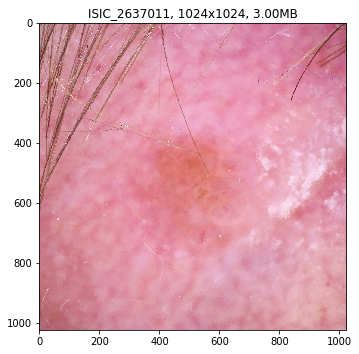

In [6]:
# initialize parser & render a smaple image
parser = TFRECParser()
parser.load('/content/gdrive/My Drive/Kaggle/melanoma/tfrecords/train*.tfrec')
parser.plot_image('ISIC_2637011')

## JPEG Qualities: Can You Tell the Difference?

In [ ]:
print('Original:')
img = parser.get_image('ISIC_0068279')
display(img)

print('\n\nCompressed (JPEG 60):')
img.save('/content/gdrive/My Drive/melanoma/temp/test60.jpg', 'JPEG', quality=60)
print ("{:.2f} MB".format(os.stat('/content/gdrive/My Drive/melanoma/temp/test60.jpg').st_size/1204/1024))
img_compress = Image.open('/content/gdrive/My Drive/melanoma/temp/test60.jpg')
display(img_compress)

print('\n\nCompressed (JPEG 100):')
img.save('/content/gdrive/My Drive/melanoma/temp/test100.jpg', 'JPEG', quality=100)
print ("{:.2f} MB".format(os.stat('/content/gdrive/My Drive/melanoma/temp/test100.jpg').st_size/1204/1024))
img_compress = Image.open('/content/gdrive/My Drive/melanoma/temp/test100.jpg')
display(img_compress)

Output hidden; open in https://colab.research.google.com to view.

## ImageDataGenerator Transformation

In [5]:
JPEG_PATH = '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_100/train/'

img = Image.open(JPEG_PATH + 'ISIC_0076545.jpg')
img_arr = np.array(img)

# transform params
# https://tinyurl.com/yazmy6of
imggen = ImageDataGenerator(vertical_flip=True,
                            horizontal_flip=True,
                            rotation_range=5,
                            fill_mode='constant',
                            dtype=np.uint8)
img_arr_t = imggen.apply_transform(x=img_arr, 
                                   transform_parameters={'theta': 10,
                                                         'flip_vertical': True,
                                                         'zx': 1,
                                                         'zy': 1})

# plot original & transformed
fig, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(img_arr)
axes[0].set_title('Original')
axes[1].imshow(img_arr_t)
axes[1].set_title('Manual Transform')

# plot random transforms
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
rotations = [0, 90, 180, 270]
for _, ax in np.ndenumerate(axes):
    i = random.randint(0, len(rotations)-1)
    img_arr_rt = imggen.apply_transform(x=img_arr, 
                                        transform_parameters={'theta': rotations[i]})
    img_arr_rt = imggen.random_transform(x=img_arr_rt)
    
    ax.imshow(img_arr_rt)
    ax.set_title('Random Transform')

plt.show()
pass

OSError: ignored

## JPG Compression

In [ ]:
# COMPRESS JPEGS

# boolean to avoid accidental compression
EXE_COMPRESSION = True
if EXE_COMPRESSION:
    parser = TFRECParser()
    parser.load('/content/gdrive/My Drive/Kaggle/melanoma/tfrecords/train*.tfrec')
    
    dataset = parser.get_dataset()
    for item in dataset:
        name = tf.compat.as_text(item['image_name'].numpy()) + '.jpg'
        img_arr = tf.image.decode_jpeg(item['image'], channels=3).numpy()

        img = Image.fromarray(img_arr)
        img.save('/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60_v2/train/' + name, 'JPEG', quality=60)

# Model Building

## Barebone CNN

In [ ]:
# global configs
CSV_TRAIN = '/content/gdrive/My Drive/Kaggle/melanoma/csv/train.csv'
CSV_TEST = '/content/gdrive/My Drive/Kaggle/melanoma/csv/test.csv'
DIR_TRAIN_IMG = '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/'
DIR_TEST_IMG =  '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/test/'

# ------------------------------------------------------------------------------
# Build the barebone cnn model...

model_cbb = Sequential()
# 1024x1024x3 => (3x3x3)x64 => 1022x1022x64
model_cbb.add(Conv2D(64, 
                     kernel_size=3, 
                     activation='relu', 
                     input_shape=(1024, 1024, 3)))
# 1022x1022x64 => (3x3x32)x32 => 1020x1020x32
model_cbb.add(Conv2D(32, 
                     kernel_size=3, 
                     activation='relu'))
# 1020x1020x32 => 33,554,432
model_cbb.add(Flatten())
# 33,554,432 => 10
model_cbb.add(Dense(2, activation='softmax'))

# compile model; use accuracy to measure model performance
# Note: 
# > Optimizer is used to accelerate gradient descent.
# > Adam accelerates GD using momentum and RMSpeop.
model_cbb.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# ------------------------------------------------------------------------------
# Build data generator and feed it to model...

# configs for training
EPOCHS = 5
BATCH_SIZE = 100
BATCH_NUM_PER_EPOCH = 1
POSITIVE_CASE_PCT = 0.5
HOLD_OUT_SIZE = 5
HOLD_OUT_POSITIVE_SIZE = 2

# build training data generator
dsm = KerasDSManager()
if not dsm.set_img_dirs(DIR_TRAIN_IMG, DIR_TEST_IMG):
    print('\nImage directories do not exist...\n')
dsm.set_img_format('jpg')

# prep data
dsm.load_csv(CSV_TRAIN, CSV_TEST)
dsm.shuffle_train()
dict_ = dsm.hold_out(n_hold=HOLD_OUT_SIZE, 
                     n_positive=HOLD_OUT_POSITIVE_SIZE)
dsm_train = dict_['train']
dsm_hold = dict_['hold']

# build generator
gen = dsm_train.get_cnn_tbg(loop=-1, 
                            max_batch_num=-1,
                            batch_size=BATCH_SIZE,
                            positive_case_pct=POSITIVE_CASE_PCT,
                            load_img_arr=True,
                            flatten_img_arr=False,
                            remove_404=True,
                            print_404=True,
                            tranform_img=True,
                            one_hot_encoding=True)

# train with generator
# Note:
# steps_per_epoch: Total # of batches to yield from generator before 
#                  declaring one epoch finished and starting the next epoch. 
#                  https://tinyurl.com/y8pcddn2
# steps_per_epoch should be smaller than the max number of batches that can be
# produced by the generator; in the case of KerasDSManager.get_cnn_tbg(), steps_per_epoch
# shuold be smaller or equal to max_batch_num
model_cbb.fit(gen,
              steps_per_epoch=BATCH_NUM_PER_EPOCH,
              epochs=EPOCHS)

# ------------------------------------------------------------------------------
# Predict hold-outs...

X_hold = dsm_hold.get_train_img_arr(True)
Y_hold = dsm_hold.train_labels

# predict and decode one hot encoding
preds = model_cbb.predict(X_hold)
preds = np.argmax(preds, axis=1)

# print prediction report
print('\nPredicting hold-outs:')
print(Y_hold)
print(classification_report(Y_hold, preds))

# ------------------------------------------------------------------------------
# Predict the last batch fed into CNN...

X_lb = dsm_train.last_batch[0]
Y_lb = dsm_train.last_batch[1]
Y_lb = np.argmax(Y_lb, axis=1)

# predict and decode one hot encoding
preds = model_cbb.predict(X_lb)
preds = np.argmax(preds, axis=1)

# print prediction report
print('\nPredicting last batch:')
print(Y_lb)
print(classification_report(Y_lb, preds))

# ------------------------------------------------------------------------------
# Predict the first batch fed into CNN...

X_fb = dsm_train.first_batch[0]
Y_fb = dsm_train.first_batch[1]
Y_fb = np.argmax(Y_fb, axis=1)

# predict and decode one hot encoding
preds = model_cbb.predict(X_fb)
preds = np.argmax(preds, axis=1)

# print prediction report
print('\nPredicting last batch:')
print(Y_fb)
print(classification_report(Y_fb, preds))

404: /content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/ISIC_1580034.jpg
404: /content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/ISIC_5407167.jpg


# Appendix: Demo Codes

In [ ]:
# data config
TRAIN_CSV_FILE = '/content/gdrive/My Drive/Kaggle/melanoma/csv/train.csv'
TRAIN_JPEG_PATH = '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train_02/'
IMG_W = 1024
IMG_H = 1024

# model configs
CONFIGS = namedtuple('CONFIGS_CNN_BAREBONE', ())
CONFIGS.EPOCHS = 1
CONFIGS.BATCH_SIZE = 1

# train_csv = pd.read_csv(TRAIN_CSV_FILE)
# train_csv.head()

img1 = Image.open(TRAIN_JPEG_PATH + 'ISIC_0052212.jpg')
img2 = Image.open(TRAIN_JPEG_PATH + 'ISIC_0075914.jpg')

# construct training/testing dataset
img1_arr = np.array(img1).reshape(IMG_W, IMG_H, 3)
img2_arr = np.array(img2).reshape(IMG_W, IMG_H, 3)
X_train = np.array([img1_arr, img2_arr])
Y_train = [0, 1]

# one-hot encoding
Y_train = to_categorical(Y_train)

# build cnn barabone
model_cbb = Sequential()
# 1024x1024x3 => (3x3x3)x64 => 1022x1022x64
model_cbb.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(1024, 1024, 3)))
# 1022x1022x64 => (3x3x32)x32 => 1020x1020x32
model_cbb.add(Conv2D(32, kernel_size=3, activation='relu'))
# 1020x1020x32 => 33,554,432
model_cbb.add(Flatten())
# 33,554,432 => 10
model_cbb.add(Dense(2, activation='softmax'))

# compile model; use accuracy to measure model performance
# Note: 
#   - Optimizer is used to accelerate gradient descent.
#   - Adam accelerates GD using momentum and RMSpeop.
model_cbb.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15,
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15,
                         horizontal_flip=True, 
                         fill_mode="constant")

# train with generator network
# steps_per_epoch: Total # of steps (images) to yield from generator before 
#                  declaring one epoch finished and starting the next epoch. 
#                  https://tinyurl.com/y8pcddn2
model_cbb.fit(aug.flow(X_train, 
                       Y_train, 
                       batch_size=CONFIGS.BATCH_SIZE),
              validation_data=(X_train, 
                               Y_train), 
              steps_per_epoch=len(X_train),
              epochs=CONFIGS.EPOCHS)

# train without generator
# model_cbb.fit(X_train, 
#               Y_train, 
#               validation_data=(X_train, Y_train), 
#               epochs=CONFIGS.EPOCHS)

# predict
preds = model_cbb.predict(X_train)
print(classification_report(Y_train, preds))

2/2 [==============================] - 1s 513ms/step - loss: 349243.7500 - accuracy: 0.0000e+00 - val_loss: 293473.4375 - val_accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2
 samples avg       0.50      0.50      0.50         2



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
